# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tqdm as tq

np.random.seed(69)

## Load *Dataset*

In [ ]:
# !gdown --id 1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg

Load data from the given pickle file

In [45]:
# mount Google Drive to access the dataset

# load the data set
with open('train_data.pkl','rb') as f:
    data = pickle.load(f)

# split into features and labels
x = data['X']
y = data['y']

# normalize
x = x/255.0

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(test_size=0.2, random_state=420)
for train_idx, test_idx in ss.split(x,y):
    train_x, train_y = x[train_idx], y[train_idx]
    test_x, test_y = x[test_idx], y[test_idx]

In [46]:
# sanity check
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(48000, 784) (48000, 1) (12000, 784) (12000, 1)


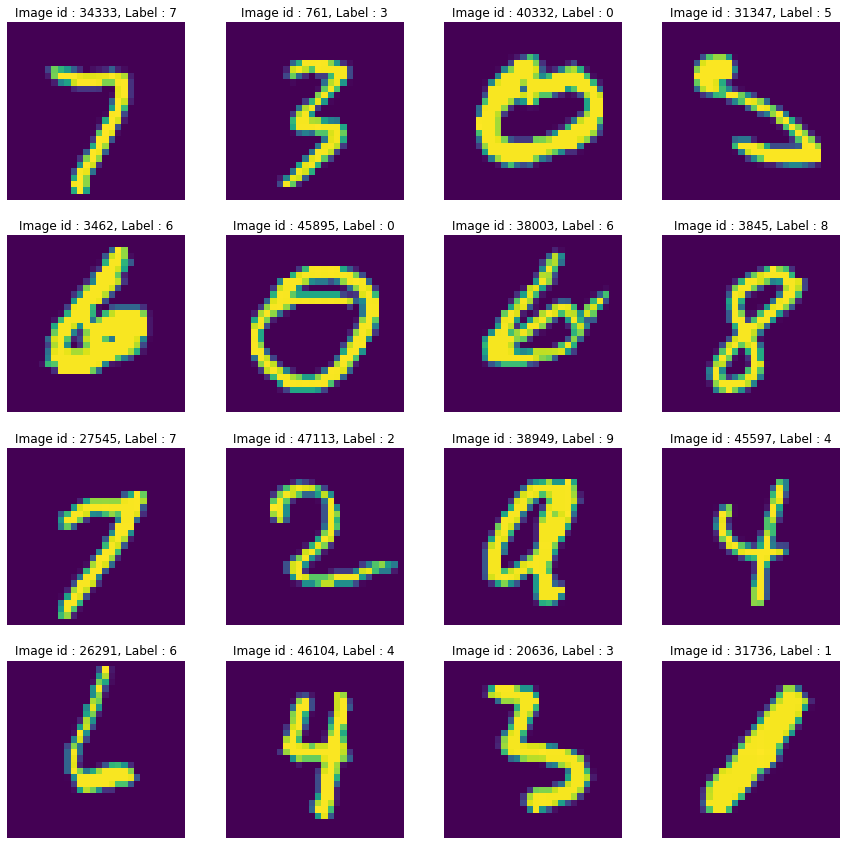

In [48]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
indices = np.random.randint(0,len(train_x),size=16)

ax = plt.subplots(4,4,figsize=(15,15))[1].flatten()

for n,idx in enumerate(indices):
    ax[n].imshow(train_x[idx].reshape(28,28))
    ax[n].set_title(f"Image id : {idx}, Label : {train_y[idx][0]}") 
    ax[n].axis('off')

## Building up parts of our classifier

**Activation functions**

In [50]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    if z < 0:
        return 0
    else:
        return z

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    return np.exp(z)/np.sum(np.exp(z))

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [53]:
def init_params(input_size, hidden_size, output_size):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    w0 = np.random.standard_normal(size=(hidden_size,input_size))
    b0 = np.zeros(shape=(hidden_size,1))
    w1 = np.random.standard_normal(size=(output_size,hidden_size))
    b1 = np.zeros(shape=(output_size,1))
    params = {
        "w0": w0,
        "b0": b0,
        "w1": w1,
        "b1": b1
    }

    return params

In [54]:
params = {
        "w0": 1,
        "b0": 1,
        "w1": 1,
        "b1": 1
    }

**Forward Propagation**

In [58]:
def forward_propg(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    w0, b0, w1, b1 = weights.values()
    z0 = np.dot(w0,X) + b0
    a0 = relu(z0)
    z1 = np.dot(w1,a0) + b1
    a1 = softmax(z1)
    out_dict = {
        "z0": z0,
        "a0": a0,
        "z1": z1,
        "a1": a1
    }

    return out_dict

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [ ]:
def backward_propg(weights, X, y, """output of forward propg"""):
    """
    should update the weights and return updated weights
    """
    
    

In [ ]:
def cost_func(weight,y,params):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    pass


## Integrate everything

In [ ]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.

    for i in range(epochs):
        # forward propagation

        # print cost at every 100 or so iterations
        
        # backward propagation
        
        pass

In [ ]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    pass

In [ ]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """

### Save as pickle

In [8]:
import pickle
import random
from google.colab import files

roll_num = "_________" # enter ldap
hidden_dim = pass # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': pass, # layer 0 weight (784, z)
    'layer_0_bias': pass, # layer 0 bias (z, 1)
    'layer_1_wt': pass, # layer 1 weight (z, 10)
    'layer_1_bias': pass # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>